In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import gamma
from sympy.printing.pretty.pretty_symbology import line_width
# from scipy.special import linestyle
from tqdm import tqdm
import scipy
import pandas as pd

from polished_scripts.utils import full_hydro_msd_no_half

In [2]:
# SHARED
_k_b = scipy.constants.k
_rho = 4200
_rho_f = 789
_r =  2.6392235755368e-06
_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.36e-3
_v_force = 6*np.pi*_r*_viscous

_K = 8.061743253740993e-05
_gain = np.sqrt(335982165125421.5 )

bin_number_data = 100
timestep_data = bin_number_data/200000000

print(timestep_data)
print("momentum relation time is " + str(_m/_v_force))
# TOLERANCES
tols = [.0051]
gap_min = 500

5e-07
momentum relation time is 1.9754935012178625e-05


In [3]:
# Calculate the average MSD
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

# Calculate the zero init MSD

def compute_init_msd(sequence):
    MS = np.zeros(len(sequence))
    for i in range(1, len(MS)):
        MS[i] = (sequence[0] - sequence[i])**2
        #print(np.abs(sequence[0] - sequence[1]) / np.abs(sequence[50] - sequence[55]))
    return MS

def compute_init_msd2(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd_ = [(time_trace[k]-time_trace[0])**2 for k in range(n)]
    return msd_, lag_times


In [4]:
# ANALYTICAL FUNCTIONS

# GENERAL WHITE NOISE
def msd_wn(t):
    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    return (2*_k_b*_temp/_K)*(1-np.exp(-t/(2*tau))*(np.cosh(omega_1*t)+(1/(2*omega_1*tau))*np.sinh(omega_1*t)))

# INITIALLY ZERO WHITE NOISE
def just_noise(t):

    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
    denominator = -2 + 8*tau**2*omega_1**2#-1*8*tau**2*omega_0**2
    final_scale = 12*np.pi*_r*_viscous*_k_b*_temp / _m**2 / omega_1**2
    return (numerator / denominator) * final_scale

# INITIAL SET VARIANCE WHITE NOISE
def known_initial_v_0(t, tol_percent):

    tau = _m / _v_force

    #Defines important auxillary variables

    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    T = omega_1*t

    #Gets contribution from the thermal white noise
    gamma = just_noise(t)

    #Gets contribution from initial position variation
    # hyp_factors = np.exp(-1*t/tau)*(np.cosh(T)**2 + 1/(4*(omega_1*tau)**2)*np.sinh(T)**2 + 1/(omega_1*tau)*np.cosh(T)*np.sinh(T)) - np.exp(-1*t/(2*tau))*(2*np.cosh(T) - 1/(2*omega_1*tau)*np.sinh(T))
    hyp_factors = (1 - np.exp(-t/(2*tau))*(np.cosh(omega_1*t) + np.sinh(omega_1*t)/(2*omega_1*tau)))**2

    #alpha easier to type than tol_percent
    alpha = tol_percent

    #Gets the second moment of the velocity assuming a probabiity distribution of
    #a Gaussian cut off on its wings by some fraction of its standard deviation (alpha/tol_percent)
    updated_sigma = 1 - alpha*np.exp(-alpha**2/2)*np.sqrt(2/np.pi)/scipy.special.erf(alpha/np.sqrt(2))

    #Calculates the contribution from the intitial velocity spread
    velo = np.exp(-1*t/tau) / omega_1**2 * np.sinh(omega_1*t)**2 *_k_b*_temp / _m * updated_sigma

    #Puts the pieces together
    return _k_b*_temp / _K * ( hyp_factors) + gamma + velo

# HYDRODYNAMIC GENERAL CASE
def hydro_msd(t):
    trap_const = _K
    use_mass = _m
    m_f = 2 / 3 * np.pi * _r ** 3 * 1000
    t_k = (6 * np.pi * _r * _viscous) / _K
    t_f = (_rho_f * _r ** 2) / _viscous
    t_p = _m / (6 * np.pi * _r * _viscous)
    print("tp is " + str(t_p))
    print(t_f)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = _k_b * _temp / (6 * np.pi * _viscous * _r)
    # Returns theoretical MSD
    return np.real(2 * _k_b * _temp / trap_const + 2 * _k_b * _temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))



In [17]:
# SIMULATIONS

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []

for chunk in pd.read_csv(r'C:\Users\mcthu\PycharmProjects\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)

# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")

bin_num_sim = 10
fs_sim = 1/(timestep_sim * bin_num_sim)
print(1/fs_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)


# GET THE EQ MSD
all_msd_sim = []
lag_times_sim = 0
for series in traces_sim:
    msd, lag_times_sim = compute_msd(series[:100000], timestep_sim*bin_num_sim)
    all_msd_sim.append(msd)

eq_msd_sim = np.mean(all_msd_sim, axis=0)



1.9754935012178623e-08


100%|██████████| 100000/100000 [00:07<00:00, 13676.34it/s]


In [6]:
# SIM PART 2

# GET THE VAR INT MSD
# CONDITIONING (Find spots where velocity is zero)
sim_tol_msds = []
init_lag_times_sim = 0

for tol in tols:
    all_init_msd_sim = []
    init_len = int(len(traces_sim[0])/1000)
    
    # msd_num_lim = 5000
    # j = 0
    
    for i in range(len(traces_sim)):
        zero_idxs_sim = []
        print("std of sim data vel " + str(np.std(v_traces_sim[i])))
        v_tolerance = (tol * np.std(v_traces_sim[i]))
        v_indices = np.where(abs(v_traces_sim[i]) < v_tolerance)[0]
        print("v idx sim: " + str(len(v_indices)))

        # last_idx = -np.inf
        #
        # p_tolerance = (tol * np.std(traces_sim[i]))
        # p_indices = np.where(abs(traces_sim[i]) < p_tolerance)[0]
        # print("p idx data: " + str(len(p_indices)))
        # overlap = np.intersect1d(v_indices, p_indices)
        # print("overlap data: " + str(len(overlap)))

        # for idx in overlap:
        #     if idx - last_idx > (init_len / gap_min) and idx + init_len < len(traces_sim[i]):
        #         zero_idxs_sim.append(idx)
        #         last_idx = idx
        # NO POSITION

        for idx in v_indices:
            if idx + init_len < len(traces_sim[i]): #idx - last_idx > (init_len / 100) and
                zero_idxs_sim.append(idx)
                last_idx = idx

        print("total idx sim: " + str(len(zero_idxs_sim)))
    
        for idx in zero_idxs_sim:
            # j+=1
            # if j > msd_num_lim:
            #     break
            msd, init_lag_times_sim = compute_init_msd2(traces_sim[i][idx:idx+init_len], timestep_sim*bin_num_sim)
            all_init_msd_sim.append(msd)
    
    init_msd_sim = np.mean(all_init_msd_sim, axis=0)
    sim_tol_msds.append(init_msd_sim)

std of sim data vel 0.00010643373808415319
v idx sim: 6488
total idx sim: 6486


In [7]:
# LOOK FOR SPECIFIC SPEEDS
# SIM PART 3
speeds = [1]
# GET THE VAR INT MSD
sim_speeds_msds = []
speed_tol = .0009
lag_times_speed = 0
for speed in speeds:
    all_speed_msd_sim = []
    init_len = int(len(traces_sim[0])/70)

    for i in range(len(traces_sim)):
        speed_idxs_sim = []
        print("std of sim data vel " + str(np.std(v_traces_sim[i])))
        v_tolerance = (speed * np.std(v_traces_sim[i]))
        speed_tolerance = speed_tol * np.std(v_traces_sim[i])
        v_indices = np.where((v_traces_sim[i] < v_tolerance + speed_tolerance) & (v_traces_sim[i] > v_tolerance - speed_tolerance))[0]
        print("speed idx sim: " + str(len(v_indices)))

        for idx in v_indices:
            if idx + init_len < len(traces_sim[i]):
                speed_idxs_sim.append(idx)

        print("total idx speed sim: " + str(len(speed_idxs_sim)))

        for idx in speed_idxs_sim:
            msd, lag_times_speed = compute_init_msd2(traces_sim[i][idx:idx+init_len], timestep_sim*bin_num_sim)
            all_speed_msd_sim.append(msd)

    speed_msd_sim = np.mean(all_speed_msd_sim, axis=0)
    sim_speeds_msds.append(speed_msd_sim)

std of sim data vel 0.00010643373808415319
speed idx sim: 683
total idx speed sim: 670


In [8]:
# DATA

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks1 = []

for chunk in pd.read_csv(r'C:\Users\mcthu\PycharmProjects\Brownian_Data_Analysis\data\barium_titanate_in_acetone_position.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks1.append(chunk)

data_df_pos_data = pd.concat(chunks1, ignore_index=True)

chunks2 = []

for chunk in pd.read_csv(r'C:\Users\mcthu\PycharmProjects\Brownian_Data_Analysis\data\barium_titanate_in_acetone_velocity.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks2.append(chunk)

data_df_vel_data = pd.concat(chunks2, ignore_index=True)

# Convert DataFrame into a numpy array where each column is an entry
traces_data = data_df_pos_data.to_numpy().T  # transpose if you want each col as an entry

# Convert DataFrame into a numpy array where each column is an entry
v_traces_data = data_df_vel_data.to_numpy().T  # transpose if you want each col as an entry


# GET THE EQ MSD
all_msd_data = []
lag_times_data = 0
for series in traces_data:
    msd, lag_times_data = compute_msd(series, timestep_data)
    all_msd_data.append(msd)

eq_msd_data = np.mean(all_msd_data, axis=0)


100%|██████████| 83886/83886 [00:03<00:00, 23871.53it/s]


In [9]:
# DATA PT 2

# GET THE VAR INT MSD
# CONDITIONING (Find spots where velocity is zero)
data_tol_msds = []
init_lag_times_data = 0
for tol in tols:
        
    all_init_msd_data = []
    init_len = int(len(traces_data[0])/10)
    #
    msd_num_lim = 5000
    j = 0
    
    for i in range(len(traces_data)):
        zero_idxs_data = []
        print("STD of vel data "+ str(np.std(v_traces_data[i])/_gain))
        v_tolerance = (tol * np.average(np.abs((v_traces_data[0]))))
        v_indices = np.where(np.abs(v_traces_data[i]) < v_tolerance)[0]
        print(v_indices)
        last_idx = -np.inf

        # p_tolerance = (tol * np.std(traces_data[i]))
        # p_indices = np.where(abs(traces_data[i]) < p_tolerance)[0]
        # print("p idx data: " + str(len(p_indices)))

        # overlap = np.intersect1d(v_indices, p_indices)
        # print("overlap idx data: " + str(len(overlap)))
        # for idx in overlap:
        #     if idx + init_len < len(traces_data[i]):#idx - last_idx > (init_len / gap_min) and
        #         zero_idxs_data.append(idx)

        # NO POSITION
        for idx in v_indices:
            if idx + init_len < len(traces_data[i]) and idx>100:
                zero_idxs_data.append(idx)

        # def find_adjacent_groups(arr):
        #     arr = np.sort(np.unique(arr))  # Sort and deduplicate
        #     splits = np.where(np.diff(arr) != 1)[0] + 1
        #     groups = np.split(arr, splits)
        #     return groups
        #
        # groups = find_adjacent_groups(zero_idxs_data)

        # zero_idxs_data_f = []
        # for group in groups:
        #     # print(group)
        #     # print(group[-1])
        #     zero_idxs_data_f.append(group[-1])
        # zero_idxs_data_ff = []
        # last_idx = -np.inf

        # for idx in zero_idxs_data_f:
        #     if idx - last_idx > (init_len / gap_min):
        #         last_idx = idx
        #         zero_idxs_data_ff.append(idx)
    
        print("total idx data: " + str(len(zero_idxs_data)))

        for idx in zero_idxs_data:
            # print(idx)
            # j+=1
            # if j > msd_num_lim:
            #     break
            msd = compute_init_msd(traces_data[i][idx:idx+init_len])
            init_lag_times_data = timestep_data*np.arange(len(msd))
            all_init_msd_data.append(msd)
    
    init_msd_data = np.mean(all_init_msd_data, axis=0)
    data_tol_msds.append(init_msd_data)

STD of vel data 0.00011773921978223673
[   86    99   719   752  2549  2684  2699  3131  3281  3404  3712  4255
  4617  4626  4778  4891  4988  5115  6021  6180  6310  6403  6437  6852
  7007  7669  8172  8457  8781  9333  9723 10613 11031 11097 11253 12008
 12047 12639 12827 14265 14444 14847 15349 15350 15625 15712 16746 17225
 17276 17433 17781 17798 18004 18095 19167 19446 19661 19874 20114 20140
 20247 20364 20929 21344 21451 21704 21890 21975 22021 23279 23291 23333
 23678 23944 24247 24622 25239 25521 25722 25973 26519 26538 26958 27178
 27660 27663 27692 28058 28201 28323 28421 28663 28845 29626 30674 30996
 31059 31166 31547 31598 31602 31854 31912 31953 32235 32662 32901 33529
 34265 34291 34716 34817 35512 35719 35732 35912 36135 36481 36516 36907
 37257 38096 38217 38485 38855 39083 39151 39460 39624 39791 40483 40553
 41229 41403 42145 42191 42855 43504 44400 44862 45324 45491 46449 46720
 46813 46837 46863 47175 47529 47890 48169 48251 48748 49068 49181 49262
 50034 50587

In [10]:

from utils import full_hydro_msd, compute_roots

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)
times_analytic = np.logspace(-9, 1, 1000)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 1000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed = np.zeros((num_samples, len(times_analytic)))
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results = np.zeros((num_samples, len(times_analytic)))
#
# for i in range(num_samples):
#     results[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], 0, roots, _temp)

speeds_analytic = []
speeds_analytic_no_half = []
for speed in speeds:
    print("Speed X")
    for i in range(num_samples):
        results_speed[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.std(v_traces_sim[0]), roots, _temp)
        results_speed_no_half[i, :] = full_hydro_msd_no_half(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.std(v_traces_sim[0]), roots, _temp)
    speeds_analytic.append(results_speed.mean(axis=0))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
    results_speed = np.zeros((num_samples, len(times_analytic)))
    results_speed_no_half = np.zeros((num_samples, len(times_analytic)))

averaged_initial_msd = results.mean(axis=0)



Speed X


tp is 1.9754935012178625e-05
1.5266056537325107e-05


C:\Users\mcthu\AppData\Local\Temp\ipykernel_26660\1809820822.py:16: RuntimeWarning: overflow encountered in exp
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\mcthu\AppData\Local\Temp\ipykernel_26660\1809820822.py:16: RuntimeWarning: overflow encountered in cosh
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\mcthu\AppData\Local\Temp\ipykernel_26660\1809820822.py:16: RuntimeWarning: invalid value encountered in add
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\mcthu\AppData\Local\Temp\ipykernel_26660\1809820822.py:16: RuntimeWarning: overflow encountered in sinh
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.

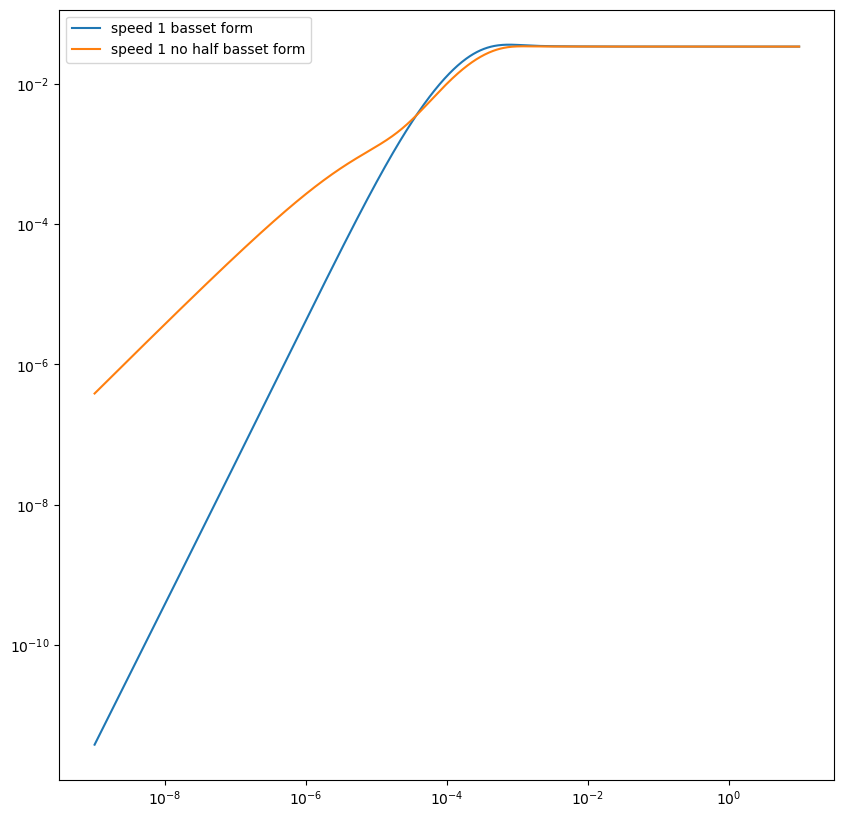

In [11]:
# GRAPHING
plt.figure(figsize=(10,10))

#  Set times for analytic functions

init_zero_WN_analytic = just_noise(times_analytic)
analytic_tol_msds = []
for tol in tols:
    init_var_WN_analytic = known_initial_v_0(times_analytic, tol)
    analytic_tol_msds.append(init_var_WN_analytic)
WN_EQ_analytic = msd_wn(times_analytic)
basset_msd = hydro_msd(times_analytic)

laplace_form = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), 0, roots, _temp)
laplace_form2 = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), (.5 * np.average(np.abs((v_traces_data[0]))))/_gain, roots, _temp)
# stationairy1 = full_hydro_msd(1000, 1000+times_analytic, _m, _K, _r, _viscous, _rho_f, np.sqrt(_k_b*_temp/_K), np.sqrt(_k_b*_temp/_m), roots, _temp)
stationairy2 = full_hydro_msd(1000, 1000+times_analytic, _m, _K, _r, _viscous, _rho_f, 0,0, roots, _temp)

def form_func(times):
    return (2/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force)) - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_5_2(times):
    return (4/3)*(12/5)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(5/2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)
def graph_2(times):
    return (2/100)*(np.sqrt((_rho_f*_r**2/_viscous)/np.pi))*(times)**(2)*(_k_b*_temp/(_m**2/_v_force))# - 2/3 * (_k_b*_temp/(_m**2/_v_force))*(times)**(3)

# ANALYTIC GRAPHING
# plt.plot(times_analytic, stationairy2*_gain**2, label="stationairy 2")
# plt.plot(times_analytic, stationairy1*_gain**2, label="stationairy 1")
# plt.plot(times_analytic, laplace_form*_gain**2, linewidth=4, label="inital zero basset", color='green')
# plt.plot(times_analytic, averaged_initial_msd*_gain**2, label="cole FORM2")
# plt.scatter(times_analytic, laplace_form2*_gain**2, s=.2, label="cole FORM2")
# plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_5_2(np.array(times_analytic[30:int(len(times_analytic)/7)]))*_gain**2, label="5/2", color='black', linewidth=3)
# plt.plot(times_analytic[30:int(len(times_analytic)/7)], graph_2(np.array(times_analytic[30:int(len(times_analytic)/7)]))*_gain**2, label="2", color='black', linewidth=3)
# plt.plot(times_analytic, init_zero_WN_analytic*_gain**2, linestyle='dashed', label="Initial Zero White")
# plt.plot(times_analytic, analytic_tol_msds[0], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[0]}")
# for i in range(len(tols)):
#     plt.plot(times_analytic, analytic_tol_msds[i], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[i]}")
# plt.plot(times_analytic, WN_EQ_analytic*_gain**2, linestyle='dashed', label="Equilibrium White")
# plt.plot(times_analytic, basset_msd*_gain**2, color='green', linewidth=4,label="Equilibrium Basset")

# SIMULATION GRAPHING
# plt.plot(lag_times_sim[1:10000], eq_msd_sim[1:10000]*_gain**2, color = "red", label="Equilibrium Basset SIM")
# plt.plot(init_lag_times_sim[1:], sim_tol_msds[-1][1:], label=f"Initial Variable Basset Variance Basset SIM tol={tols[0]}")
# for i in range(len(tols)):
    # plt.plot(init_lag_times_sim[40:], sim_tol_msds[i][40:]*_gain**2, linestyle = 'dashed', color = "red", label=f"Initial Variable Basset Variance Basset SIM tol={tols[i]}")

# SPEEDS
for i in range(len(speeds)):
    # plt.plot(lag_times_speed[:], sim_speeds_msds[i][:]*_gain**2, linestyle = 'dashed', label=f"Speed Basset Variance Basset SIM tol={speeds[i]}")
    plt.plot(times_analytic, speeds_analytic[i]*_gain**2, label=f"speed {speeds[i]} basset form")
    plt.plot(times_analytic, speeds_analytic_no_half[i]*_gain**2, label=f"speed {speeds[i]} no half basset form")


# DATA GRAPHING
# plt.scatter(lag_times_data[1:], eq_msd_data[1:],s=20, label="Equilibrium Basset DATA", color = "blue")
# plt.plot(init_lag_times_data, data_tol_msds[0], linestyle='dotted', label=f"Initial Variable Basset Variance Basset DATA tol={tols[0]}")
# for i in range(len(tols)):
    # plt.scatter(init_lag_times_data, data_tol_msds[i], s=20, color = "blue", label=f"Initial Variable Basset Variance Basset DATA tol={tols[i]}")

# data = np.column_stack((init_lag_times_data, data_tol_msds[0]))
# a_form = np.column_stack((times_analytic, laplace_form*_gain**2))
# eq_data = np.column_stack((lag_times_data[1:], eq_msd_data[1:]))
# eq_form = np.column_stack((times_analytic, basset_msd*_gain**2))

# Save to a text file
# np.savetxt('../data/data.dat', data, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/a_form.dat', a_form, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/eq_data.dat', eq_data, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')
# np.savetxt('../data/eq_form.dat', eq_form, fmt='%.15e', delimiter=' ', header='# lag msd_z_ic', comments='')

# ONE TIME GRAPH
# plt.plot(times_analytic, analytic_tol_msds[0], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[0]}")
# plt.plot(times_analytic, analytic_tol_msds[-1], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[-1]}")
# plt.plot(times_analytic, analytic_tol_msds[3], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[3]}")
#
# plt.plot(init_lag_times_sim[1:], sim_tol_msds[0][1:], label=f"Initial Variable Basset Variance Basset SIM tol={tols[0]}")
# plt.plot(init_lag_times_sim[1:], sim_tol_msds[-1][1:], label=f"Initial Variable Basset Variance Basset SIM tol={tols[-1]}")
# plt.plot(init_lag_times_sim[1:], sim_tol_msds[3][1:], label=f"Initial Variable Basset Variance Basset SIM tol={tols[3]}")


# plt.xlim(left =1E-7, right=5E-2)
# plt.ylim(bottom=1E-8, top =5e-2)
# plt.xlim(left =3E-7, right=5E-5)
# plt.ylim(bottom=1E-22, top =5e-18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


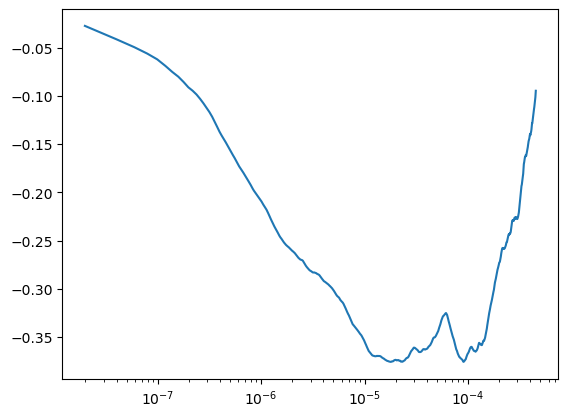

In [12]:
from scipy.interpolate import interp1d
s_interp = interp1d(times_analytic, speeds_analytic[0])

a_speed = s_interp(lag_times_speed[1:])
diff = (sim_speeds_msds[0][1:] - a_speed)/a_speed
plt.plot(lag_times_speed[1:],diff, label=f"Speed difference")
# plt.xlim(left = 0, right = 2e-5)
plt.xscale('log')
plt.show()

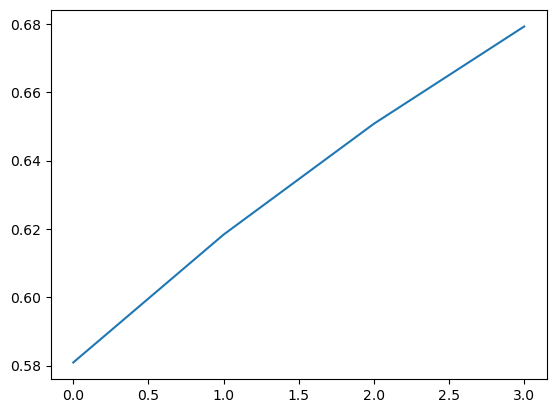

In [13]:
from scipy.interpolate import interp1d #find ratio
off_by = []

f = interp1d(times_analytic, form_func(np.array(times_analytic))*_gain**2, kind='linear')

interpolated_arr2 = f(init_lag_times_sim[1:])

ratio =  sim_tol_msds[i][1:]*_gain**2 / interpolated_arr2

plt.plot(ratio[5:9])

In [14]:
# restrict to overlapping domain
from scipy.interpolate import interp1d

crossings_for_tols = []

for i in range(len(tols)):

    x1 = times_analytic
    x2 = init_lag_times_sim[1:]
    y1 = analytic_tol_msds[i]
    y2 = sim_tol_msds[i][1:]

    xmin = max(x1.min(), x2.min())
    xmax = min(x1.max(), x2.max())

    if xmin>xmax:
        print("Error: No overlapping domain")
    else:
        x_common = np.linspace(xmin, xmax, 100000)

        #interpolate both functions
        f_1 = interp1d(x1, y1, kind='linear',bounds_error=False, fill_value=np.nan)
        f_2 = interp1d(x2, y2, kind='linear',bounds_error=False, fill_value=np.nan)

        y1_interp = f_1(x_common)
        y2_interp = f_2(x_common)

        # Find a sign change in the difference
        diff = y1_interp - y2_interp
        mask = ~np.isnan(diff)
        diff = diff[mask]
        x_common = x_common[mask]
        sign_changes = np.where(np.diff(np.sign(diff)))[0]

        x_crossings = []
        for j in sign_changes:
            x0, x1 = x_common[j], x_common[j+1]
            y0, y1_ = diff[j], diff[j+1]
            x_cross = x0 - y0 * (x1 - x0) / (y1_ - y0)
            x_crossings.append(x_cross)

        if not x_crossings:
            print(f"No crossing found for tol: {tols[i]}")
        else:
            print(f"{len(x_crossings)} crossings found for tol: {tols[i]}")

        crossings_for_tols.append(x_crossings)

print(crossings_for_tols)

1 crossings found for tol: 0.0051
[[1.960909381454455e-05]]


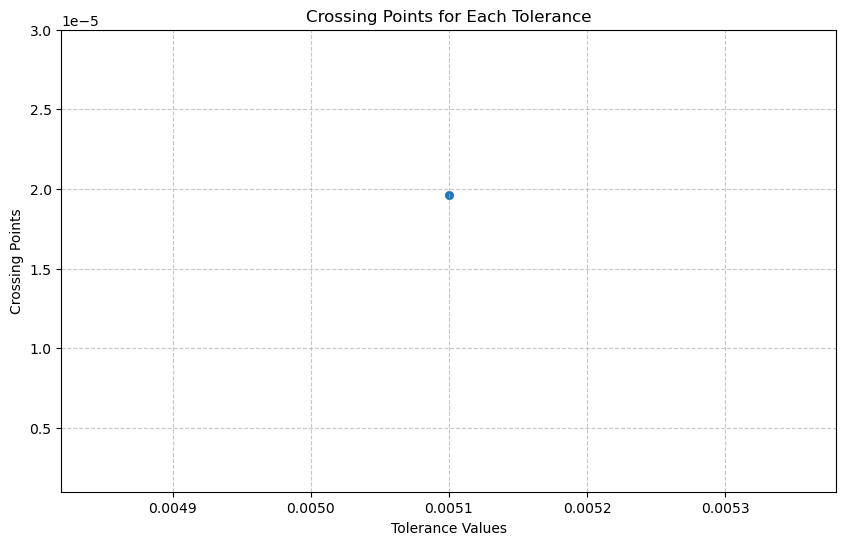

In [15]:

x_values = []
y_values = []

for i, tol in enumerate(tols):
    # For each tolerance, repeat the tol value for each crossing
    num_crossings = len(crossings_for_tols[i])
    x_values.extend([tol] * num_crossings)  # Repeat tol for each crossing
    y_values.extend(crossings_for_tols[i])   # Add all crossings as y-values

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, linewidth=0.5)

# Customize the plot
plt.xlabel('Tolerance Values')
plt.ylabel('Crossing Points')
plt.title('Crossing Points for Each Tolerance')
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Use log scale if tolerance values vary widely
# plt.xscale('log')
plt.ylim(bottom=.1E-5, top = 3E-5)
plt.show()

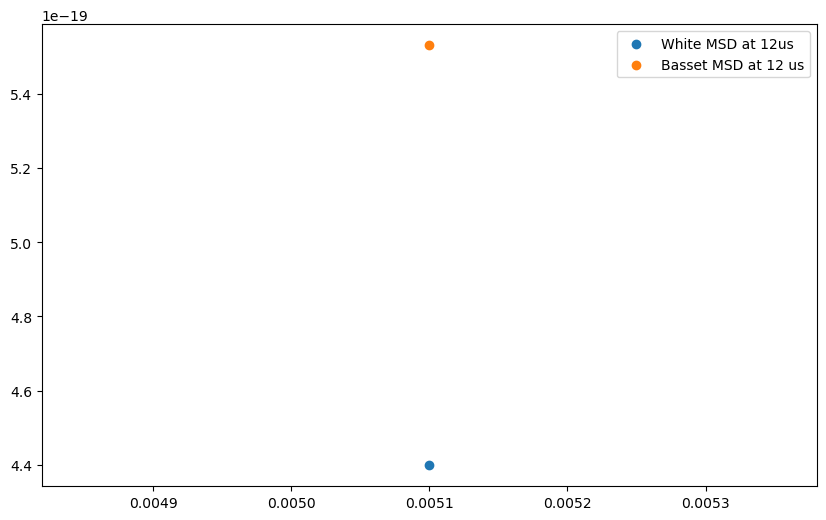

In [16]:
# Find the msd val for every tolerance (both analytical and sim) at 12 microseconds and plot against tolerances

twelve_us_msd_white = []
twelve_us_msd_basset = []

for i in range(len(tols)):
    x1 = times_analytic
    x2 = init_lag_times_sim[1:]
    y1 = analytic_tol_msds[i]
    y2 = sim_tol_msds[i][1:]
    
    f_1 = interp1d(x1, y1, kind='linear',bounds_error=False, fill_value=np.nan)
    f_2 = interp1d(x2, y2, kind='linear',bounds_error=False, fill_value=np.nan)
    
    twelve_us_msd_white.append(f_1(1.2e-5))
    twelve_us_msd_basset.append(f_2(1.2e-5))
    
plt.figure(figsize=(10, 6))
plt.scatter(tols, twelve_us_msd_white, label='White MSD at 12us')
plt.scatter(tols, twelve_us_msd_basset, label='Basset MSD at 12 us')
plt.legend()
plt.show()